# Acknowledgement
This notebook is an improvement on the solution posted here
https://github.com/chetanambi/Zindi-Solutions/tree/master/Urban-Air-Pollution-Challenge

# Resources
https://www.mikulskibartosz.name/forecasting-time-series-using-lag-features/
https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/
https://en.wikipedia.org/wiki/Precipitation_types 
https://www.sciencedirect.com/science/article/pii/S1877050920312060
https://catboost.ai/docs/concepts/python-usages-examples.html#cross-validation 
https://lightgbm.readthedocs.io/en/latest/Parameters.html 
https://neptune.ai/blog/lightgbm-parameters-guide

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from math import sqrt 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold, train_test_split

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# Import Datasets

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub  = pd.read_csv('SampleSubmission.csv')

# Data Pre-processing

In [3]:
train.shape, test.shape, sub.shape

((30557, 82), (16136, 77), (16136, 2))

In [4]:
train.head(2)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.0,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,22.379054,-0.000010,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,NaN,NaN,0.000000,NaN,NaN,NaN,76.536426,38.593017,-61.752587,22.363665,NaN,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.00004,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.6,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.115179,233.313706,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.022017,1148.985447,61.216687,841116.763051,-57.015200,61.402626,-74.457583,33.089495,0.000114,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.000171,0.858446,175.019862,99354.162958,0.059358,5.958538,175.072145,99353.672374,-14.708036,59.624912,-67.693509,28.614804,0.315403,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000150,0.433957,0.00005,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652


In [5]:
test.head(2)

,Place_ID X Date,Date,Place_ID,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,0OS9LVX X 2020-01-02,2020-01-02,0OS9LVX,11.600000,30.200001,0.00409,14.656824,3.956377,0.712605,0.000053,0.000108,0.466171,0.010752,835670.492740,68.099367,1.445658,-95.984984,22.942019,0.000046,6156.074219,0.000007,0.113310,227.467539,0.032071,68.099367,1.445658,-95.984984,22.942019,0.017953,841.142869,155.982981,835625.785337,32.709708,1.898112,-95.987015,22.950150,0.000073,0.032071,68.099367,1.445658,-95.984984,22.942019,0.000088,1.494039,2592.634167,74028.429228,0.032268,6.317523,2593.137433,74023.930722,68.099367,1.445658,-95.984984,22.942019,0.299053,0.466173,835670.492740,68.099367,1.445658,-95.984984,22.942019,0.000221,0.784436,0.000184,-0.140458,0.032071,68.099367,1.445658,-95.984984,22.942019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0OS9LVX X 2020-01-03,2020-01-03,0OS9LVX,18.300001,42.900002,0.00595,15.026544,4.230430,0.661892,0.000050,0.000109,-0.213659,0.028307,835281.882757,75.936844,34.638933,-95.017976,18.539524,0.000045,7311.869141,0.000005,0.110397,227.788713,0.044784,75.936845,34.639165,-95.017596,18.539491,0.019576,1187.570320,922.385833,835225.278332,73.808143,34.720869,-95.017095,18.548551,0.000048,0.040803,75.936813,34.641758,-95.014908,18.539116,0.000074,1.534485,7334.601102,48466.653300,0.046211,8.308433,7902.937546,46345.613031,75.936845,34.639165,-95.017596,18.539491,0.290397,-0.213657,835281.882757,75.936844,34.638933,-95.017976,18.539524,0.000034,0.678988,0.000014,-0.842713,0.040803,75.936813,34.641758,-95.014908,18.539116,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sub.head(2)

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,0
1,0OS9LVX X 2020-01-03,0


In [7]:
train.isnull().sum()

Place_ID X Date                                            0
Date                                                       0
Place_ID                                                   0
target                                                     0
target_min                                                 0
target_max                                                 0
target_variance                                            0
target_count                                               0
precipitable_water_entire_atmosphere                       0
relative_humidity_2m_above_ground                          0
specific_humidity_2m_above_ground                          0
temperature_2m_above_ground                                0
u_component_of_wind_10m_above_ground                       0
v_component_of_wind_10m_above_ground                       0
L3_NO2_NO2_column_number_density                        2189
L3_NO2_NO2_slant_column_number_density                  2189
L3_NO2_absorbing_aerosol

In [8]:
train.columns

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
   

In [9]:
train['Date'] = pd.to_datetime(train['Date'])
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['Dayofweek'] = train['Date'].dt.dayofweek
train['DayOfyear'] = train['Date'].dt.dayofyear
train['WeekOfyear'] = train['Date'].dt.weekofyear

test['Date'] = pd.to_datetime(test['Date'])
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['Dayofweek'] = test['Date'].dt.dayofweek
test['DayOfyear'] = test['Date'].dt.dayofyear
test['WeekOfyear'] = test['Date'].dt.weekofyear

In [10]:
# Creating columns for precipitation categories
# light < 2.5, moderate 2.5 - 10.0, heavy 10.0 - 50.0, violent > 50.0
train['prep_cat'] = ['light' if 0<precipitable_water_entire_atmosphere<2.5 else 'moderate' \
                      if 2.4<precipitable_water_entire_atmosphere<10.0 else 'heavy' if 9.9<precipitable_water_entire_atmosphere<50.0 \
                      else 'violent' if 49.9<precipitable_water_entire_atmosphere<74.0 else None \
                      for precipitable_water_entire_atmosphere in list(train['precipitable_water_entire_atmosphere'].values)]

test['prep_cat'] = ['light' if 0<precipitable_water_entire_atmosphere<2.5 else 'moderate' \
                      if 2.4<precipitable_water_entire_atmosphere<10.0 else 'heavy' if 9.9<precipitable_water_entire_atmosphere<50.0 \
                      else 'violent' if 49.9<precipitable_water_entire_atmosphere<74.0 else None \
                      for precipitable_water_entire_atmosphere in list(test['precipitable_water_entire_atmosphere'].values)]

In [11]:
# creating a labelEncoder object
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() #Bound labelEncoder to le to reduceName
#transforming prep_cat into numerical values
train['prep_cat'] = le.fit_transform(train['prep_cat'])
test['prep_cat'] = le.fit_transform(test['prep_cat'])

In [12]:
train.head(2)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle,Month,Day,Dayofweek,DayOfyear,WeekOfyear,prep_cat
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.0,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,22.379054,-0.000010,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,NaN,NaN,0.000000,NaN,NaN,NaN,76.536426,38.593017,-61.752587,22.363665,NaN,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.00004,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118,1,2,3,2,1,0
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.6,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.115179,233.313706,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.022017,1148.985447,61.216687,841116.763051,-57.015200,61.402626,-74.457583,33.089495,0.000114,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.000171,0.858446,175.019862,99354.162958,0.059358,5.958538,175.072145,99353.672374,-14.708036,59.624912,-67.693509,28.614804,0.315403,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000150,0.433957,0.00005,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652,1,3,4,3,1,0


In [13]:
train.drop(['Place_ID X Date','Date','Place_ID','target_min','target_max','target_variance','target_count','L3_CH4_CH4_column_volume_mixing_ratio_dry_air',
       'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth',
       'L3_CH4_sensor_azimuth_angle', 'L3_CH4_sensor_zenith_angle',
       'L3_CH4_solar_azimuth_angle', 'L3_CH4_solar_zenith_angle'], axis=1, inplace=True)
test.drop(['Place_ID X Date','Date','Place_ID', 'L3_CH4_CH4_column_volume_mixing_ratio_dry_air',
       'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth',
       'L3_CH4_sensor_azimuth_angle', 'L3_CH4_sensor_zenith_angle',
       'L3_CH4_solar_azimuth_angle', 'L3_CH4_solar_zenith_angle'], axis=1, inplace=True)

In [14]:
train.shape, test.shape

((30557, 74), (16136, 73))

In [15]:
#train = train.fillna(0) 
#test = test.fillna(0)  
import datasist as ds
train = ds.feature_engineering.fill_missing_num(train)
test = ds.feature_engineering.fill_missing_num(test)

In [16]:
lag_features = ['relative_humidity_2m_above_ground',
                'v_component_of_wind_10m_above_ground',
                'L3_NO2_NO2_column_number_density',
                'L3_HCHO_tropospheric_HCHO_column_number_density',
                'L3_CLOUD_surface_albedo',
                'L3_CO_CO_column_number_density',
                'temperature_2m_above_ground',
                'L3_CLOUD_cloud_optical_depth',
                'L3_O3_O3_column_number_density'
                ]

for feat in lag_features:
    for i in range(3):
        train[feat+'_lag'+str(i+1)] = train[feat].shift(i+1)
        test[feat+'_lag'+str(i+1)] = test[feat].shift(i+1)

In [17]:
X = train.drop(labels=['target'], axis=1)
y = train['target'].values

# Train test split

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=1)

In [19]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((22917, 100), (22917,), (7640, 100), (7640,))

In [20]:
X.head(5)

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,Month,Day,Dayofweek,DayOfyear,WeekOfyear,prep_cat,relative_humidity_2m_above_ground_lag1,relative_humidity_2m_above_ground_lag2,relative_humidity_2m_above_ground_lag3,v_component_of_wind_10m_above_ground_lag1,v_component_of_wind_10m_above_ground_lag2,v_component_of_wind_10m_above_ground_lag3,L3_NO2_NO2_column_number_density_lag1,L3_NO2_NO2_column_number_density_lag2,L3_NO2_NO2_column_number_density_lag3,L3_HCHO_tropospheric_HCHO_column_number_density_lag1,L3_HCHO_tropospheric_HCHO_column_number_density_lag2,L3_HCHO_tropospheric_HCHO_column_number_density_lag3,L3_CLOUD_surface_albedo_lag1,L3_CLOUD_surface_albedo_lag2,L3_CLOUD_surface_albedo_lag3,L3_CO_CO_column_number_density_lag1,L3_CO_CO_column_number_density_lag2,L3_CO_CO_column_number_density_lag3,temperature_2m_above_ground_lag1,temperature_2m_above_ground_lag2,temperature_2m_above_ground_lag3,L3_CLOUD_cloud_optical_depth_lag1,L3_CLOUD_cloud_optical_depth_lag2,L3_CLOUD_cloud_optical_depth_lag3,L3_O3_O3_column_number_density_lag1,L3_O3_O3_column_number_density_lag2,L3_O3_O3_column_number_density_lag3
0,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,22.379054,-0.000010,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,2510.989311,77491.774334,0.000000,18.201564,3286.134009,70799.498221,76.536426,38.593017,-61.752587,22.363665,0.226843,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.000040,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1,2,3,2,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.

# Build Model

In [21]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_valid, label=y_valid)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'rmse',
         'learning_rate': 0.05, 
         'num_iterations': 7500,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction': 0.8,
         'bagging_freq': 1,
         'feature_fraction': 0.8
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=100,
                verbose_eval=500,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_valid) 

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 25.4566
[1000]	valid_0's rmse: 24.7011
[1500]	valid_0's rmse: 24.3774
[2000]	valid_0's rmse: 24.2048
[2500]	valid_0's rmse: 24.0883
[3000]	valid_0's rmse: 24.024
[3500]	valid_0's rmse: 23.9831
[4000]	valid_0's rmse: 23.9485
[4500]	valid_0's rmse: 23.9314
[5000]	valid_0's rmse: 23.9141
[5500]	valid_0's rmse: 23.903
[6000]	valid_0's rmse: 23.8931
[6500]	valid_0's rmse: 23.8878
[7000]	valid_0's rmse: 23.8821
[7500]	valid_0's rmse: 23.8791
Did not meet early stopping. Best iteration is:
[7487]	valid_0's rmse: 23.8789


In [22]:
y_pred

array([61.81795984, 75.43374424, 63.1662833 , ..., 40.01766523,
       70.03414212, 34.77173283])

In [23]:
np.sqrt(mean_squared_error(y_valid, y_pred)) # 23.878924083698397

23.878924083698397

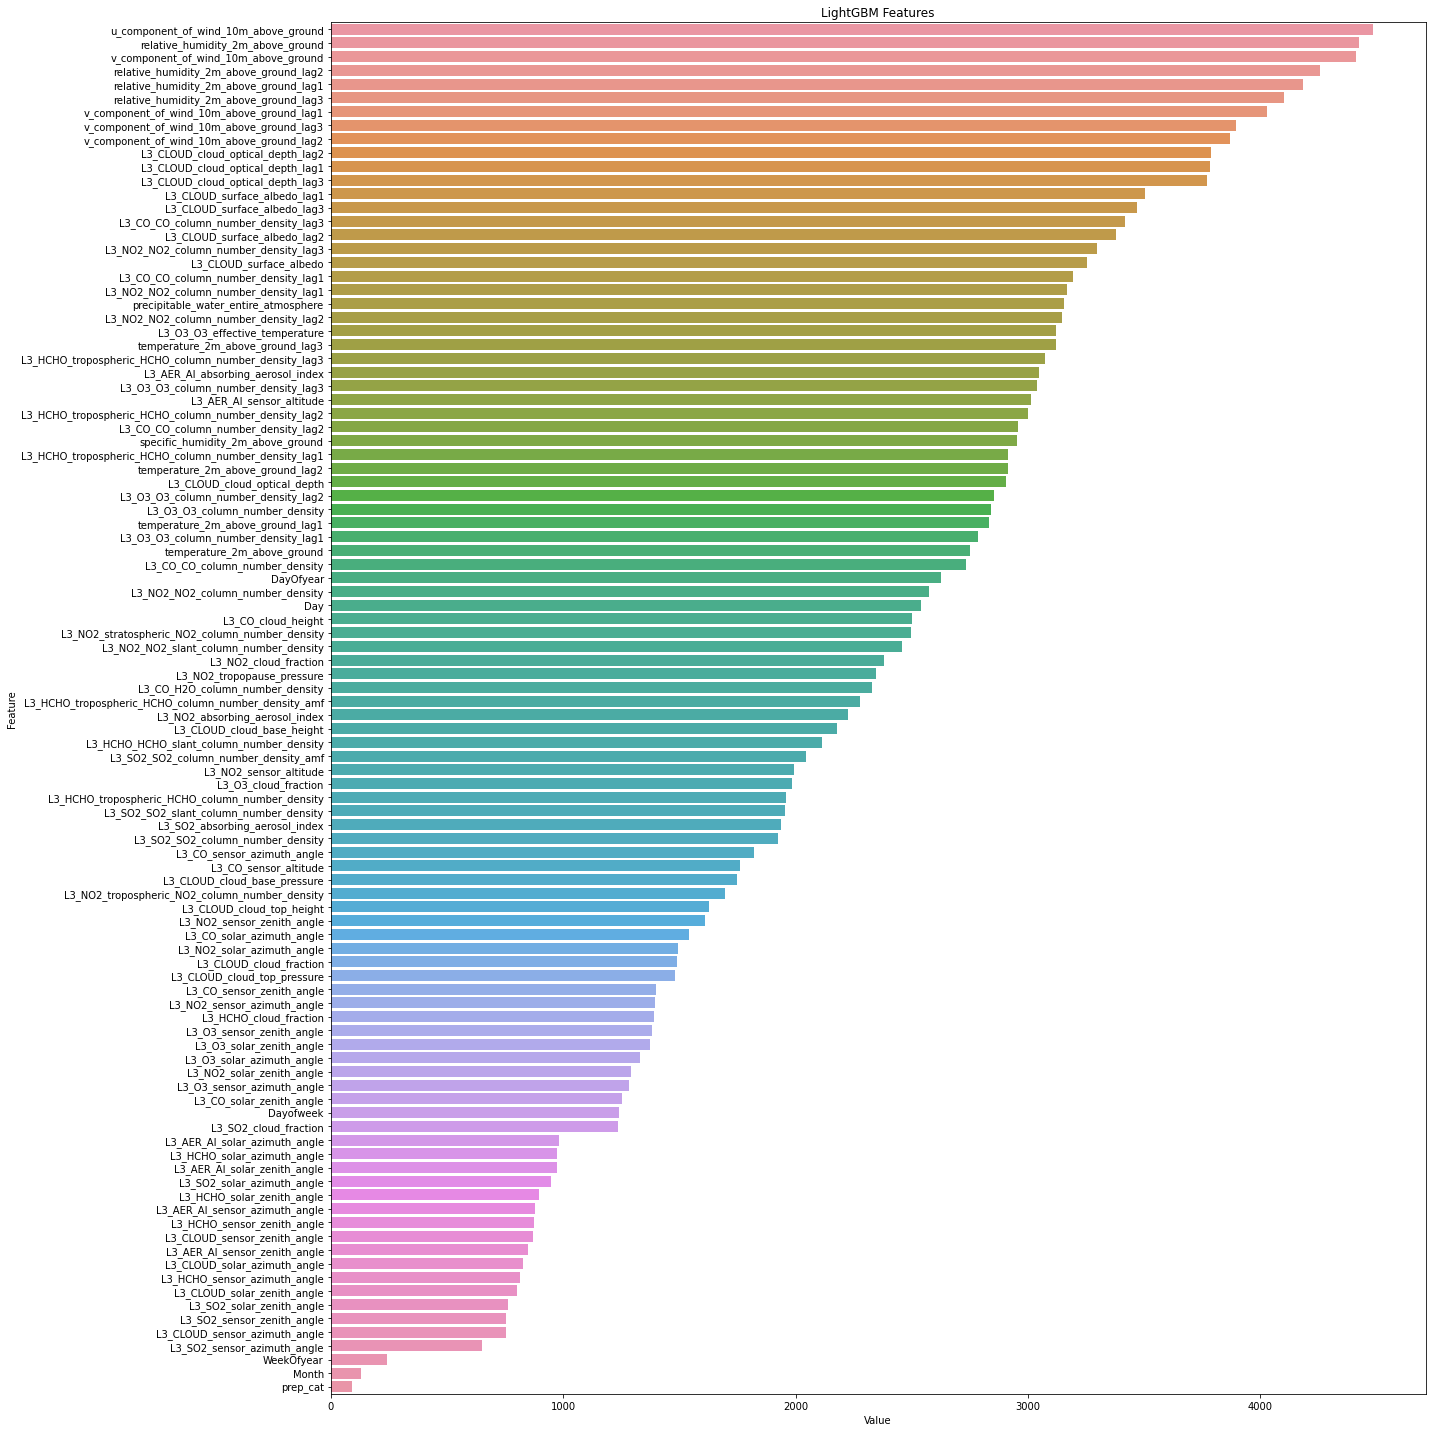

In [24]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(20,20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

# Predict on Test Set

In [25]:
Xtest = test

In [26]:
errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=500,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test) 

    print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
    errlgb.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    p = clf.predict(Xtest)
    
    y_pred_totlgb.append(p)

Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 25.1176
[1000]	valid_0's rmse: 24.1607
[1500]	valid_0's rmse: 23.7795
[2000]	valid_0's rmse: 23.5369
[2500]	valid_0's rmse: 23.4293
[3000]	valid_0's rmse: 23.3277
[3500]	valid_0's rmse: 23.2555
[4000]	valid_0's rmse: 23.2189
[4500]	valid_0's rmse: 23.1887
[5000]	valid_0's rmse: 23.1719
[5500]	valid_0's rmse: 23.1534
[6000]	valid_0's rmse: 23.1355
[6500]	valid_0's rmse: 23.1272
[7000]	valid_0's rmse: 23.1202
[7500]	valid_0's rmse: 23.1155
Did not meet early stopping. Best iteration is:
[7488]	valid_0's rmse: 23.1153
RMSE:  23.115318813007455
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 28.377
[1000]	valid_0's rmse: 27.4609
[1500]	valid_0's rmse: 27.0836
[2000]	valid_0's rmse: 26.8376
[2500]	valid_0's rmse: 26.7117
[3000]	valid_0's rmse: 26.6133
[3500]	valid_0's rmse: 26.54
[4000]	valid_0's rmse: 26.5001
[4500]	valid_0's rmse: 26.4739
[5000]	valid_0's rmse: 26.4493
[

In [27]:
np.mean(y_pred_totlgb,0)

array([89.69306289, 50.74121338, 41.89732504, ..., 51.22498107,
       40.47888071, 34.93210359])

In [28]:
np.mean(errlgb, 0)

24.35910813948471

# Submission

In [29]:
y_pred = np.mean(y_pred_totlgb,0)

In [30]:
sub['target'] = y_pred

In [31]:
sub.head()

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,89.693063
1,0OS9LVX X 2020-01-03,50.741213
2,0OS9LVX X 2020-01-04,41.897325
3,0OS9LVX X 2020-01-05,41.674447
4,0OS9LVX X 2020-01-06,28.498450


In [32]:
sub.to_csv('lgbpred.csv', index=False)